In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import cv2


# Load CIFAR-10 Dataset

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                         download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True)

classes = trainset.classes


# Simple CNN Model (Perfect for Grad-CAM)

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(64 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 32x32 → 16x16
        x = self.pool(F.relu(self.conv2(x)))  # 16x16 → 8x8
        x = self.pool(F.relu(self.conv3(x)))  # 8x8 → 4x4

        x = x.view(-1, 64 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x


# Train the Model (Short Training for Demo)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(3):  # small epochs for demo
    running_loss = 0.0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss:.3f}")


Epoch 1, Loss: 1166.518
Epoch 2, Loss: 853.407
Epoch 3, Loss: 722.774


# Grad-CAM Implementation (Core XAI Part)

In [ ]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        target_layer.register_forward_hook(self.forward_hook)
        target_layer.register_backward_hook(self.backward_hook)

    def forward_hook(self, module, input, output):
        self.activations = output

    def backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate(self, input_tensor, target_class=None):
        self.model.zero_grad()
        output = self.model(input_tensor)

        if target_class is None:
            target_class = torch.argmax(output)

        output[0][target_class].backward()

        gradients = self.gradients
        activations = self.activations

        weights = torch.mean(gradients, dim=(2, 3), keepdim=True)
        cam = torch.sum(weights * activations, dim=1)

        cam = F.relu(cam)
        cam = cam - cam.min()
        cam = cam / cam.max()

        return cam.detach().cpu().numpy()


# Run Grad-CAM on a Test Image

In [ ]:
data_iter = iter(testloader)
image, label = next(data_iter)

image = image.to(device)
label = label.to(device)

model.eval()
output = model(image)
pred = torch.argmax(output)

print("Predicted:", classes[pred])
print("Actual:", classes[label])


Predicted: deer
Actual: deer


# Generate Heatmap

In [ ]:
gradcam = GradCAM(model, model.conv3)
cam = gradcam.generate(image, pred.item())

heatmap = cv2.resize(cam[0], (32, 32))
heatmap = np.uint8(255 * heatmap)

heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)


# Overlay Heatmap on Original Image

✅ Which region of the CIFAR-10 image influenced the CNN decision

✅ Visual attention region

✅ Real explainability for deep CNN

✅ Perfect for Agentic AI + Vision XAI demo

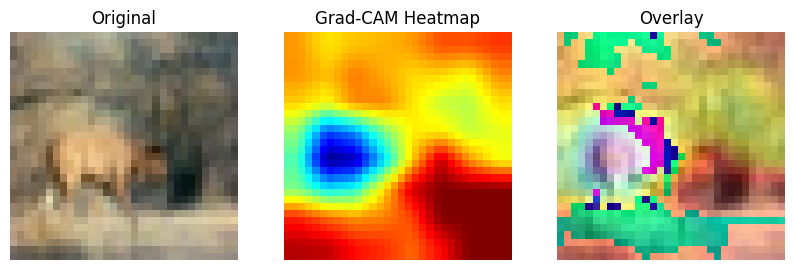

In [ ]:
original = image.cpu().squeeze().permute(1, 2, 0).numpy()
original = (original * 0.5) + 0.5  # denormalize

overlay = heatmap * 0.4 + (original * 255)

plt.figure(figsize=(10, 4))

plt.subplot(1, 3, 1)
plt.title("Original")
plt.imshow(original)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Grad-CAM Heatmap")
plt.imshow(heatmap)
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Overlay")
plt.imshow(np.uint8(overlay))
plt.axis("off")

plt.show()
